In [3]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import os


Loading of sequences and calulated descriptors

In [2]:
# Connect to the database and read the data
if os.getenv("SNAKEMAKE_EXECUTION"):
    # Adjust paths for Snakemake execution
    output = "./05-logistic_regression/roc.pdf"
    db_path = "./unified-final.db"
else:
    # Adjust paths for local execution
    output = "roc.pdf"
    db_path = "../unified-final.db"



# Connect to the database and read the data
con = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM prod_desc", con)

df["AB"] = df["AB"].apply(lambda x: int.from_bytes(x, "little"))
columns_to_drop = ["index", "id", "name", "description", "OX", "source", "valid", "level_0"]
df = df.drop(columns=columns_to_drop)
df



NameError: name 'os' is not defined

In [4]:
# split of data to target
X = df.drop(columns=['AB',"seq"])
y = df['AB']




initial PCA with 99 % variance

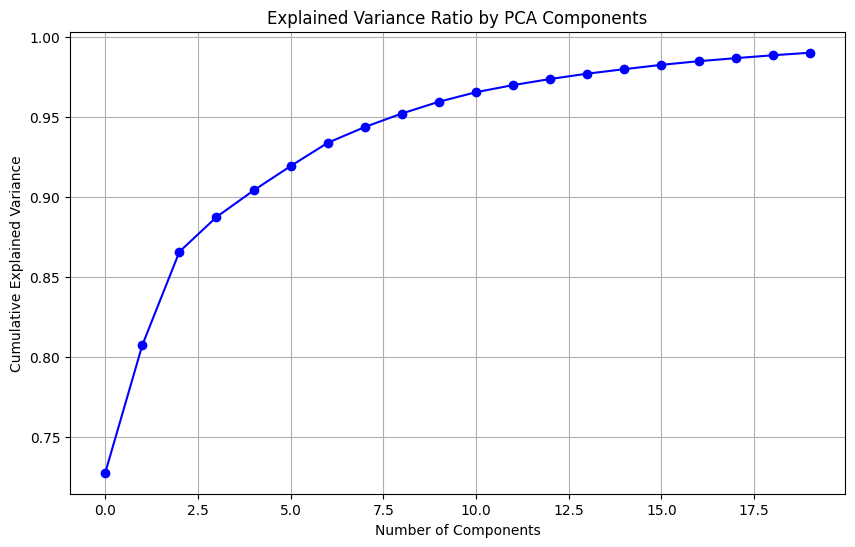

Number of components to explain 99% variance: 20


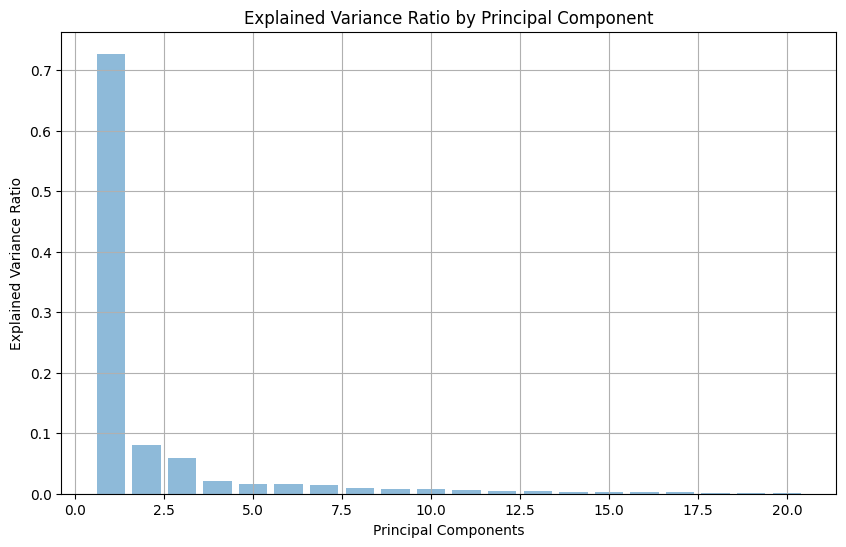

In [53]:


# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio by PCA Components')
plt.grid(True)
plt.show()

# Number of components
num_components = pca.n_components_
print(f"Number of components to explain 99% variance: {num_components}")

# Optionally, you can also visualize the explained variance ratio for each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, align='center', alpha=0.5)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.grid(True)
plt.show()


In [7]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, shuffle = True)

pipeline set up

In [8]:
from sklearn.decomposition import KernelPCA

# Define the pipeline components
scaler = MinMaxScaler()
pca = PCA(n_components =0.99)
svc = SVC(probability=True)

# Define the pipeline
pipeline = make_pipeline(scaler, pca, svc, verbose=True)

bayesian hyperparameter tuning, in previous opt process C = 37, gamma = 0.09 and best kernel = rbf were identified, so they were used as specific points and exploitation was favoured

In [26]:
from bayes_opt import UtilityFunction

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=54)

# Kernel mapping
kernel_map = {0: 'linear', 1: 'poly', 2: 'rbf', 3: 'sigmoid'}

# Bayesian Optimization function
def optimize_svm(C, gamma):
    kernel = 2
    pipeline.set_params(svc__C=C, svc__gamma=gamma, svc__kernel="rbf")
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1, verbose=3)
    return cv_scores.mean()

# Define the parameter bounds for optimization
pbounds = {
    'C': (30, 50),
    'gamma': (0.07, 0.12),

}

optimizer.probe(
    params={"C": 37.454637344617396, "gamma":  0.09507635921035062},
    lazy=True,
)

# Perform Bayesian Optimization
optimizer = BayesianOptimization(
    f=optimize_svm,
    pbounds=pbounds,
    random_state=42, 
    verbose=2,
)


acquisition_function = UtilityFunction(kind="ei", xi=1e-4)
optimizer.maximize(n_iter=25, acquisition_function=acquisition_function)

# Get the best parameters
best_params = optimizer.max['params']
best_params['kernel'] = "rbf"
print("Best Hyperparameters:", best_params)

# Update the pipeline with the best parameters
pipeline.set_params( svc__C=best_params['C'], svc__gamma=best_params['gamma'], svc__kernel=best_params['kernel'])


|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 1         | 0.7798    | 37.49     | 0.1175    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 2         | 0.7783    | 44.64     | 0.09993   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 3         | 0.7694    | 33.12     | 0.0778    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 4         | 0.7788    | 31.16     | 0.1133    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 5         | 0.7795    | 42.02     | 0.1054    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.9s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 6         | 0.7718    | 37.45     | 0.08591   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 7         | 0.7743    | 46.57     | 0.08501   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 8         | 0.774     | 32.03     | 0.09608   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 9         | 0.7719    | 30.11     | 0.09319   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 10        | 0.7793    | 43.35     | 0.1021    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


| 11        | 0.7691    | 30.65     | 0.08076   |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 12        | 0.7792    | 38.84     | 0.1112    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 13        | 0.7709    | 30.37     | 0.09192   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 14        | 0.7751    | 37.9      | 0.09437   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 15        | 0.7724    | 43.8      | 0.07612   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 16        | 0.7724    | 42.08     | 0.07758   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


| 17        | 0.7811    | 45.86     | 0.1142    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 18        | 0.7717    | 38.39     | 0.07827   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 19        | 0.7694    | 32.3      | 0.07992   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 20        | 0.7745    | 49.11     | 0.08307   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 21        | 0.7798    | 46.27     | 0.1101    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 22        | 0.7791    | 34.17     | 0.1088    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 23        | 0.7791    | 46.38     | 0.104     |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


| 24        | 0.7785    | 40.04     | 0.1036    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 25        | 0.7794    | 42.69     | 0.1083    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 26        | 0.7791    | 38.19     | 0.1101    |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 27        | 0.7712    | 31.36     | 0.09056   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 28        | 0.7789    | 30.53     | 0.115     |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   59.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


| 29        | 0.7726    | 42.96     | 0.07586   |


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min


| 30        | 0.7739    | 39.27     | 0.08815   |


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


KeyError: 'kernel'

Best Hyperparameters: {'C': 45.86  , 'gamma': 0.1142, 'kernel': 'rbf'}

Training model with tuned hyperparameter, learning curve, ROC curve, classification matrix, F1-score and accuracy

[learning_curve] Training set sizes: [ 737 1474 2211 2948 3686 4423 5160 5897 6634 7372]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  3.5min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.5min finished


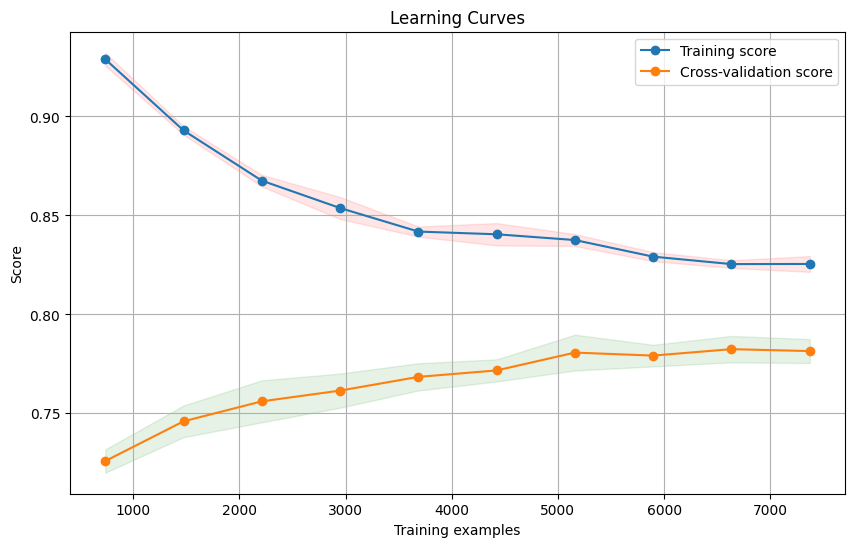

[Pipeline] ...... (step 1 of 3) Processing minmaxscaler, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total=  55.7s
Test Accuracy: 0.7792
F1 score: 0.7906
Confusion Matrix:
[[835 244]
 [265 961]]


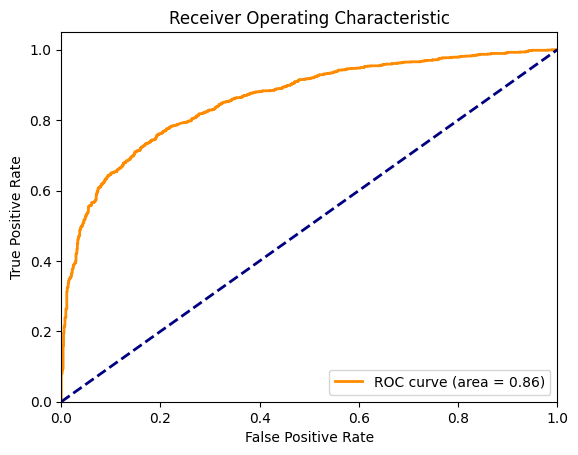

In [27]:
from sklearn.model_selection import learning_curve, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Initialise KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=9)

# Compute learning curves
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Vary the training set sizes
    cv=kf,  # Cross-validation strategy
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available CPUs
    verbose = 2
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, 
                 np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                 alpha=0.1, color='r')
plt.fill_between(train_sizes, 
                 np.mean(valid_scores, axis=1) - np.std(valid_scores, axis=1),
                 np.mean(valid_scores, axis=1) + np.std(valid_scores, axis=1), 
                 alpha=0.1, color='g')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Train the model on the entire training set for final evaluation
pipeline.fit(X_train, y_train)

# Predictions for test set using trained model
y_pred = pipeline.predict(X_test)

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate predicted probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
plt.savefig(output)


misclassified sequences analysis; take indices and identify sequences

In [28]:
#take only sequences
df = df["seq"]

# Identify indices of falsely classified instances
false_indices = np.where(y_test != y_pred)[0]

# Select corresponding rows from the original DataFrame 'df'
false_classified_df = df.iloc[false_indices]

Get aino acid composition for misclassified

In [29]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    'GetAAComp'
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(false_classified_df)

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
aa_df = pd.concat([false_classified_df, features_df], axis=1)



Extracting Features: 100%|███████████████████████████████████████████████████████| 509/509 [00:00<00:00, 169827.44it/s]


Get doublet composition for misclassified

In [30]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    
    'GetDPComp',
    
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(false_classified_df)

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
dp_df = pd.concat([false_classified_df, features_df], axis=1)







Extracting Features: 100%|█████████████████████████████████████████████████████████| 509/509 [00:00<00:00, 1927.56it/s]


Get triplet composition for misclassified

In [31]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    
    'GetTPComp'
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(false_classified_df)

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
tp_df = pd.concat([false_classified_df, features_df], axis=1)



Extracting Features: 100%|███████████████████████████████████████████████████████████| 509/509 [03:51<00:00,  2.20it/s]


Combine and show most frequent amino acids

In [32]:
# Assuming df1, df2, and df3 are your DataFrames
datasets = [aa_df, dp_df, tp_df]

# Iterate over each dataset
for idx, df in enumerate(datasets, start=1):
    column_sums = df.iloc[:, 1:].sum()  # Calculate the sum of values in each column excluding the first column
    highest_sums = column_sums.nlargest(3)  # Get the top 3 columns with the highest sums
    print(f"Top columns in dataset {idx}:")
    print(highest_sums)


Top columns in dataset 1:
L    4324.500
G    4149.557
K    4143.838
dtype: float64
Top columns in dataset 2:
KK    601.13
LL    457.82
AA    412.22
dtype: float64
Top columns in dataset 3:
PRP    31.0
LKK    27.0
KKL    22.0
dtype: float64


In [38]:
df_false_pca = false_classified_df

df_false_kpca = pd.read_csv("false_classified_kpca.csv")

Get common misclassified indices from both PCA svm and kPCA svm

In [39]:
common_indices = df_false_pca.index.intersection(df_false_kpca.index)

# Calculate and print the number of common indices
num_common_indices = len(common_indices)
print(f"Number of common indices between df_false_pca and df_false_kpca: {num_common_indices}")

Number of common indices between df_false_pca and df_false_kpca: 101


Get sequences from common misclassified

In [46]:
common_seq = df_false_pca.loc[common_indices]

get amino acid composition for common misclassified

In [47]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    'GetAAComp'
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(common_seq)

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
aa_df = pd.concat([common_seq, features_df], axis=1)



Extracting Features: 100%|███████████████████████████████████████████████████████| 101/101 [00:00<00:00, 101007.32it/s]


In [ ]:
get doublet composition for common misclassified

In [48]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    
    'GetDPComp',
    
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(common_seq)

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
dp_df = pd.concat([common_seq, features_df], axis=1)







Extracting Features: 100%|██████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 924.52it/s]


In [ ]:
get triplet composition for common misclassified

In [49]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    
    'GetTPComp'
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(common_seq)

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
tp_df = pd.concat([common_seq, features_df], axis=1)



Extracting Features: 100%|███████████████████████████████████████████████████████████| 101/101 [00:32<00:00,  3.10it/s]


combine and show which are most frequent for common misclassified

In [51]:
# Assuming df1, df2, and df3 are your DataFrames
datasets = [aa_df, dp_df, tp_df]

# Iterate over each dataset
for idx, df in enumerate(datasets, start=1):
    column_sums = df.iloc[:, 1:].sum()  # Calculate the sum of values in each column excluding the first column
    highest_sums = column_sums.nlargest(3)  # Get the top 3 columns with the highest sums
    print(f"Top columns in dataset {idx}:")
    print(highest_sums)


Top columns in dataset 1:
A    918.344
L    872.980
V    732.426
dtype: float64
Top columns in dataset 2:
AL    112.30
LP    106.09
GV    105.89
dtype: float64
Top columns in dataset 3:
KKL    6.0
PRP    6.0
AVA    5.0
dtype: float64
